In [23]:
import subprocess
import re
import sys
import os
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed
import math
import pandas as pd
from typing import Dict
from typing import Optional, Dict

def parse_training_result(file_path: str) -> Optional[Dict[str, float]]:
    """
    Parses a training result text file to extract mode, start times, end times, and durations.

    Args:
        file_path (str): Path to the text file to parse.

    Returns:
        Optional[Dict[str, float]]: A dictionary containing the extracted information.
            - For 'cephfs' mode:
                {
                    "mode": "cephfs",
                    "data_loading_start": float,
                    "data_loading_end": float,
                    "data_loading_duration": float
                }
            - For 'ramfs' mode:
                {
                    "mode": "ramfs",
                    "prefetching_start": float,
                    "prefetching_end": float,
                    "prefetching_duration": float,
                    "data_loading_start": float,
                    "data_loading_end": float,
                    "data_loading_duration": float
                }
            Returns None if an error occurs during parsing.
    """
    result = {}
    
    # Define regex patterns
    cephfs_pattern = re.compile(
        r'Data loading start at (\d+\.\d+) and end (\d+\.\d+) for (\d+\.\d+)second'
    )
    ramfs_prefetch_pattern = re.compile(
        r'prefetching start time (\d+\.\d+) end (\d+\.\d+) for total (\d+\.\d+)second'
    )
    data_loading_pattern = re.compile(
        r'Data loading start at (\d+\.\d+) and end (\d+\.\d+) for (\d+\.\d+)second'
    )
    
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        
        if not lines:
            print(f"Error: The file '{file_path}' is empty.")
            return None
        
        # Determine mode from the first line
        first_line = lines[0].strip().lower()
        if first_line.startswith("cephfs is getting tested"):
            result["mode"] = "cephfs"
            
            # Search for the data loading line
            data_loading_found = False
            for line in lines:
                match = cephfs_pattern.search(line)
                if match:
                    result["data_loading_start"] = float(match.group(1))
                    result["data_loading_end"] = float(match.group(2))
                    result["data_loading_duration"] = float(match.group(3))
                    data_loading_found = True
                    break
            if not data_loading_found:
                print("Error: Data loading information not found for cephfs mode.")
                return None
        
        elif first_line.startswith("ramfs is getting tested"):
            result["mode"] = "ramfs"
            
            # Search for the prefetching line
            prefetching_found = False
            for line in lines:
                match = ramfs_prefetch_pattern.search(line)
                if match:
                    result["prefetching_start"] = float(match.group(1))
                    result["prefetching_end"] = float(match.group(2))
                    result["prefetching_duration"] = float(match.group(3))
                    prefetching_found = True
                    break
            if not prefetching_found:
                print("Error: Prefetching information not found for ramfs mode.")
                return None
            
            # Search for the data loading line
            data_loading_found = False
            for line in lines:
                match = data_loading_pattern.search(line)
                if match:
                    result["data_loading_start"] = float(match.group(1))
                    result["data_loading_end"] = float(match.group(2))
                    result["data_loading_duration"] = float(match.group(3))
                    data_loading_found = True
                    break
            if not data_loading_found:
                print("Error: Data loading information not found for ramfs mode.")
                return None
        
        else:
            print("Error: Unknown mode. The first line must start with 'cephfs is getting tested' or 'ramfs is getting tested'.")
            return None
        
        return result
    
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' does not exist.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while parsing the file: {e}")
        return None


def read_inventory_file(inventory_file):
    with open(inventory_file, 'r') as f:
        ips = [line.strip() for line in f if line.strip()]
    return ips

    
def run_query_on_node(ip, ssh_user, ssh_key, start_time, end_time):
    ssh_command = [
        'ssh',
        '-o', 'StrictHostKeyChecking=no',
        f'{ssh_user}@{ip}',
    ]
    if ssh_key:
        ssh_command.extend(['-i', ssh_key])
    remote_command = (
        f'python3 /home/cc/MultiNodeEnergyTracker/query_database.py --start {start_time} --end {end_time}'
    )
    full_command = ssh_command + [remote_command]
    try:
        result = subprocess.run(full_command, capture_output=True, text=True, timeout=120)
        if result.returncode != 0:
            print(f"Error executing command on {ip}: {result.stderr}", file=sys.stderr)
            return None
        return result.stdout.strip()
    except subprocess.TimeoutExpired:
        print(f"Timeout occurred while querying {ip}.", file=sys.stderr)
        return None
    except Exception as e:
        print(f"Exception occurred while querying {ip}: {e}", file=sys.stderr)
        return None


def parse_query_output(output):
    pattern = re.compile(
    r'(?P<node>[\w-]+): Number of entries: (?P<entries>\d+), CPU Energy: (?P<cpu_energy>[0-9.]+), '
    r'Memory Energy: (?P<memory_energy>[0-9.]+), GPU Energy: (?P<gpu_energy>[0-9.]+)'
    )
    match = pattern.search(output)
    if match:
        return {
            'node': match.group('node'),
            'entries': int(match.group('entries')),
            'cpu_energy': float(match.group('cpu_energy')),
            'memory_energy': float(match.group('memory_energy')),
            'gpu_energy': float(match.group('gpu_energy')),
        }
    else:
        print(f"Failed to parse output: {output}", file=sys.stderr)
        return None

def adjust_energy_values(parsed_output, start_time, end_time):
    actual_entries = parsed_output['entries']
    duration = end_time - start_time
    expected_entries = math.ceil(duration / 0.1)  # 0.1s resolution
    if actual_entries == 0:
        print(f"No entries for node {parsed_output['node']} between {start_time} and {end_time}", file=sys.stderr)
        return None

    adjustment_factor = expected_entries / actual_entries

    adjusted_cpu_energy = parsed_output['cpu_energy'] * adjustment_factor
    adjusted_memory_energy = parsed_output['memory_energy'] * adjustment_factor
    adjusted_gpu_energy = parsed_output['gpu_energy'] * adjustment_factor

    return {
        'node': parsed_output['node'],
        'adjusted_cpu_energy': adjusted_cpu_energy,
        'adjusted_memory_energy': adjusted_memory_energy,
        'adjusted_gpu_energy': adjusted_gpu_energy,
    }


def extract_epoch_mode_regex(file_path: str) -> Optional[str]:
    """
    Extracts the 'epoch_X_mode' part from the given file path using regex.

    Args:
        file_path (str): Absolute path to the result text file.

    Returns:
        Optional[str]: Extracted 'epoch_X_mode' string or None if pattern doesn't match.
    """
    # Extract the basename from the file path
    basename = os.path.basename(file_path)  # e.g., 'epoch_1_cephfs_result.txt'
    
    # Define a regex pattern to match 'epoch_X_mode_result.txt'
    pattern = r'^(epoch_\d+_(cephfs|ramfs))_result\.txt$'
    
    match = re.match(pattern, basename)
    if match:
        # The first capturing group contains 'epoch_X_mode'
        return match.group(1)
    else:
        # If the pattern does not match, return None or handle accordingly
        print(f"Warning: The file '{basename}' does not match the expected regex pattern.")
        return None

def collect_and_process(txt_file):
    time_pairs = parse_training_result(txt_file)
    ips = read_inventory_file("/home/cc/MultiNodeEnergyTracker/inventory.txt")
    final_results = {}    
    if time_pairs['mode']== 'cephfs':
        print(f"\nProcessing phase '{time_pairs['mode']}' from {time_pairs['data_loading_start']} to {time_pairs['data_loading_end']}")
        expected_entries = math.ceil((time_pairs['data_loading_end'] - time_pairs['data_loading_start']) / 0.1)
        duration = round((time_pairs['data_loading_end'] - time_pairs['data_loading_start']),2)
        print(f"Expected entries: {expected_entries:.2f}")
        with ThreadPoolExecutor(max_workers=3) as executor:
            future_to_ip = {
                executor.submit(run_query_on_node, ip, "cc", "~/.ssh/id_rsa", time_pairs['data_loading_start'], time_pairs['data_loading_end']): ip
                for ip in ips
            }
            for future in as_completed(future_to_ip):
                ip = future_to_ip[future]
                try:
                    output = future.result()
                    if output is None:
                        continue
                    parsed_output = parse_query_output(output)
                    # print(parsed_output)
                    if parsed_output is None:
                        continue
                    adjusted_values = adjust_energy_values(parsed_output, time_pairs['data_loading_start'], time_pairs['data_loading_end'])
                    # print(adjusted_values)
                    if adjusted_values is None:
                        continue
                    node = adjusted_values['node']
                    if node not in final_results:
                        final_results[node] = {}
                    final_results[node][time_pairs['mode']] = {
                        'adjusted_cpu_energy': adjusted_values['adjusted_cpu_energy'],
                        'adjusted_memory_energy': adjusted_values['adjusted_memory_energy'],
                        'adjusted_gpu_energy': adjusted_values['adjusted_gpu_energy'],
                        'Duration': duration
                    }
                except Exception as e:
                    print(f"Error processing node {ip}: {e}", file=sys.stderr)
        print(final_results)

    elif time_pairs['mode']== 'ramfs':
        print(f"\nProcessing phase '{time_pairs['mode']}' from {time_pairs['data_loading_start']} to {time_pairs['data_loading_end']} and {time_pairs['prefetching_start']} to {time_pairs['prefetching_end']}")
        expected_entries = math.ceil((time_pairs['data_loading_end'] - time_pairs['data_loading_start']) / 0.1)
        duration = round((time_pairs['data_loading_end'] - time_pairs['data_loading_start']),2)
        expected_entries_prefetch = math.ceil((time_pairs['prefetching_end'] - time_pairs['prefetching_start']) / 0.1)
        duration_prefetch = round((time_pairs['prefetching_end'] - time_pairs['prefetching_start']),2)

        
        print(f"Expected entries: {expected_entries:.2f} and {expected_entries_prefetch:.2f}")
        with ThreadPoolExecutor(max_workers=3) as executor:
            future_to_ip = {
                executor.submit(run_query_on_node, ip, "cc", "~/.ssh/id_rsa", time_pairs['data_loading_start'], time_pairs['data_loading_end']): ip
                for ip in ips
            }
            for future in as_completed(future_to_ip):
                ip = future_to_ip[future]
                try:
                    output = future.result()
                    if output is None:
                        continue
                    parsed_output = parse_query_output(output)
                    # print(parsed_output)
                    if parsed_output is None:
                        continue
                    adjusted_values = adjust_energy_values(parsed_output, time_pairs['data_loading_start'], time_pairs['data_loading_end'])
                    # print(adjusted_values)
                    if adjusted_values is None:
                        continue
                    node = adjusted_values['node']
                    if node not in final_results:
                        final_results[node] = {}
                    final_results[node][time_pairs['mode']] = {
                        'adjusted_cpu_energy': adjusted_values['adjusted_cpu_energy'],
                        'adjusted_memory_energy': adjusted_values['adjusted_memory_energy'],
                        'adjusted_gpu_energy': adjusted_values['adjusted_gpu_energy'],
                        'Duration': duration
                    }
                except Exception as e:
                    print(f"Error processing node {ip}: {e}", file=sys.stderr)
        with ThreadPoolExecutor(max_workers=3) as executor:
            future_to_ip = {
                executor.submit(run_query_on_node, ip, "cc", "~/.ssh/id_rsa", time_pairs['data_loading_start'], time_pairs['data_loading_end']): ip
                for ip in ips
            }
            for future in as_completed(future_to_ip):
                ip = future_to_ip[future]
                try:
                    output = future.result()
                    if output is None:
                        continue
                    parsed_output = parse_query_output(output)
                    # print(parsed_output)
                    if parsed_output is None:
                        continue
                    adjusted_values = adjust_energy_values(parsed_output, time_pairs['data_loading_start'], time_pairs['data_loading_end'])
                    # print(adjusted_values)
                    if adjusted_values is None:
                        continue
                    node = adjusted_values['node']
                    if node not in final_results:
                        final_results[node] = {}
                    final_results[node][time_pairs['mode']] = {
                        'adjusted_cpu_energy': adjusted_values['adjusted_cpu_energy'],
                        'adjusted_memory_energy': adjusted_values['adjusted_memory_energy'],
                        'adjusted_gpu_energy': adjusted_values['adjusted_gpu_energy'],
                        'Duration': duration
                    }
                except Exception as e:
                    print(f"Error processing node {ip}: {e}", file=sys.stderr)
            
        print(final_results)

    
        

In [26]:
base_energies={"compute1":{"memory":13,"cpu":107,"gpu":51},"storage1":{"memory":15,"cpu":78,"gpu":0},"storage2":{"memory":7,"cpu":87,"gpu":0}}


list_of_files=["epoch_1_cephfs_result.txt" ,"epoch_1_ramfs_result.txt"]
base_directories= "/home/cc/MultiNodeEnergyTracker/results/"
for file in list_of_files:
    results= parse_training_result(base_directories+file)
    print(f"for {file} results are {results}")
    # print(extract_epoch_mode_regex(base_directories+file))
    # collect_and_process(base_directories+file)

for epoch_1_cephfs_result.txt results are {'mode': 'cephfs', 'data_loading_start': 1734387650.9066136, 'data_loading_end': 1734388040.502449, 'data_loading_duration': 389.5958354473114}
for epoch_1_ramfs_result.txt results are {'mode': 'ramfs', 'prefetching_start': 1734387337.2065308, 'prefetching_end': 1734387457.460072, 'prefetching_duration': 120.2535412311554, 'data_loading_start': 1734387457.9295802, 'data_loading_end': 1734387618.417442, 'data_loading_duration': 160.48786187171936}


In [7]:
final_re

['10.52.3.192', '10.52.2.190', '10.52.3.86']


In [6]:
python3 /home/cc/MultiNodeEnergyTracker/query_database.py --start 1734387650.9066136 --end 1734388040.502449

/home/cc


In [10]:
import subprocess
import re
import sys
import os
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed
import math
import pandas as pd
from typing import Dict, Optional, List


def parse_training_result(file_path: str) -> Optional[Dict[str, float]]:
    """
    Parses a training result text file to extract mode, start times, end times, and durations.

    Args:
        file_path (str): Path to the text file to parse.

    Returns:
        Optional[Dict[str, float]]: A dictionary containing the extracted information.
            - For 'cephfs' mode:
                {
                    "mode": "cephfs",
                    "data_loading_start": float,
                    "data_loading_end": float,
                    "data_loading_duration": float
                }
            - For 'ramfs' mode:
                {
                    "mode": "ramfs",
                    "prefetching_start": float,
                    "prefetching_end": float,
                    "prefetching_duration": float,
                    "data_loading_start": float,
                    "data_loading_end": float,
                    "data_loading_duration": float
                }
            Returns None if an error occurs during parsing.
    """
    result = {}

    # Define regex patterns
    cephfs_pattern = re.compile(
        r'Data loading start at (\d+\.\d+) and end (\d+\.\d+) for (\d+\.\d+)second'
    )
    ramfs_prefetch_pattern = re.compile(
        r'prefetching start time (\d+\.\d+) end (\d+\.\d+) for total (\d+\.\d+)second'
    )
    data_loading_pattern = re.compile(
        r'Data loading start at (\d+\.\d+) and end (\d+\.\d+) for (\d+\.\d+)second'
    )

    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        if not lines:
            print(f"Error: The file '{file_path}' is empty.", file=sys.stderr)
            return None

        # Determine mode from the first line
        first_line = lines[0].strip().lower()
        if first_line.startswith("cephfs is getting tested"):
            result["mode"] = "cephfs"

            # Search for the data loading line
            data_loading_found = False
            for line in lines:
                match = cephfs_pattern.search(line)
                if match:
                    result["data_loading_start"] = float(match.group(1))
                    result["data_loading_end"] = float(match.group(2))
                    result["data_loading_duration"] = float(match.group(3))
                    data_loading_found = True
                    break
            if not data_loading_found:
                print("Error: Data loading information not found for cephfs mode.", file=sys.stderr)
                return None

        elif first_line.startswith("ramfs is getting tested"):
            result["mode"] = "ramfs"

            # Search for the prefetching line
            prefetching_found = False
            for line in lines:
                match = ramfs_prefetch_pattern.search(line)
                if match:
                    result["prefetching_start"] = float(match.group(1))
                    result["prefetching_end"] = float(match.group(2))
                    result["prefetching_duration"] = float(match.group(3))
                    prefetching_found = True
                    break
            if not prefetching_found:
                print("Error: Prefetching information not found for ramfs mode.", file=sys.stderr)
                return None

            # Search for the data loading line
            data_loading_found = False
            for line in lines:
                match = data_loading_pattern.search(line)
                if match:
                    result["data_loading_start"] = float(match.group(1))
                    result["data_loading_end"] = float(match.group(2))
                    result["data_loading_duration"] = float(match.group(3))
                    data_loading_found = True
                    break
            if not data_loading_found:
                print("Error: Data loading information not found for ramfs mode.", file=sys.stderr)
                return None

        else:
            print("Error: Unknown mode. The first line must start with 'cephfs is getting tested' or 'ramfs is getting tested'.", file=sys.stderr)
            return None

        return result

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' does not exist.", file=sys.stderr)
        return None
    except Exception as e:
        print(f"An unexpected error occurred while parsing the file: {e}", file=sys.stderr)
        return None


def read_inventory_file(inventory_file: str) -> List[str]:
    """
    Reads an inventory file and returns a list of IPs.

    Args:
        inventory_file (str): Path to the inventory file.

    Returns:
        List[str]: List of IP addresses.
    """
    try:
        with open(inventory_file, 'r') as f:
            ips = [line.strip() for line in f if line.strip()]
        return ips
    except FileNotFoundError:
        print(f"Error: Inventory file '{inventory_file}' not found.", file=sys.stderr)
        return []
    except Exception as e:
        print(f"Error reading inventory file '{inventory_file}': {e}", file=sys.stderr)
        return []


def run_query_on_node(ip: str, ssh_user: str, ssh_key: str, start_time: float, end_time: float) -> Optional[str]:
    """
    Executes a remote query on a node via SSH.

    Args:
        ip (str): IP address of the node.
        ssh_user (str): SSH username.
        ssh_key (str): Path to the SSH private key.
        start_time (float): Start time for the query.
        end_time (float): End time for the query.

    Returns:
        Optional[str]: Output from the remote command or None if an error occurs.
    """
    ssh_command = [
        'ssh',
        '-o', 'StrictHostKeyChecking=no',
        f'{ssh_user}@{ip}',
    ]
    if ssh_key:
        ssh_command.extend(['-i', ssh_key])
    remote_command = (
        f'python3 /home/cc/MultiNodeEnergyTracker/query_database.py --start {start_time} --end {end_time}'
    )
    full_command = ssh_command + [remote_command]
    try:
        result = subprocess.run(full_command, capture_output=True, text=True, timeout=120)
        if result.returncode != 0:
            print(f"Error executing command on {ip}: {result.stderr}", file=sys.stderr)
            return None
        return result.stdout.strip()
    except subprocess.TimeoutExpired:
        print(f"Timeout occurred while querying {ip}.", file=sys.stderr)
        return None
    except Exception as e:
        print(f"Exception occurred while querying {ip}: {e}", file=sys.stderr)
        return None


def parse_query_output(output: str) -> Optional[Dict[str, float]]:
    """
    Parses a single line of training output to extract node information and energy metrics.

    Args:
        output (str): A single line of output from the training script.

    Returns:
        Optional[Dict[str, float]]: A dictionary containing the extracted information:
            - 'node' (str): Name of the node.
            - 'entries' (int): Number of entries processed.
            - 'cpu_energy' (float): CPU energy consumed.
            - 'memory_energy' (float): Memory energy consumed.
            - 'gpu_energy' (float): GPU energy consumed.
        Returns None if parsing fails.
    """
    # Updated regex pattern to include hyphens in node names and handle optional spaces
    pattern = re.compile(
        r'(?P<node>[\w-]+):\s*Number of entries:\s*(?P<entries>\d+),\s*'
        r'CPU Energy:\s*(?P<cpu_energy>[0-9]*\.?[0-9]+),\s*'
        r'Memory Energy:\s*(?P<memory_energy>[0-9]*\.?[0-9]+),\s*'
        r'GPU Energy:\s*(?P<gpu_energy>[0-9]*\.?[0-9]+)',
        re.IGNORECASE  # Makes the pattern case-insensitive
    )
    match = pattern.search(output)
    if match:
        try:
            return {
                'node': match.group('node'),
                'entries': int(match.group('entries')),
                'cpu_energy': float(match.group('cpu_energy')),
                'memory_energy': float(match.group('memory_energy')),
                'gpu_energy': float(match.group('gpu_energy')),
            }
        except ValueError as ve:
            print(f"Value conversion error: {ve} in output: {output}", file=sys.stderr)
            return None
    else:
        print(f"Failed to parse output: {output}", file=sys.stderr)
        return None


def adjust_energy_values(parsed_output: Dict[str, float], start_time: float, end_time: float) -> Optional[Dict[str, float]]:
    """
    Adjusts energy values based on the expected number of entries.

    Args:
        parsed_output (Dict[str, float]): Parsed output containing 'entries' and energy metrics.
        start_time (float): Start time of the period.
        end_time (float): End time of the period.

    Returns:
        Optional[Dict[str, float]]: Adjusted energy metrics or None if actual entries are zero.
    """
    actual_entries = parsed_output['entries']
    duration = end_time - start_time
    expected_entries = math.ceil(duration / 0.1)  # 0.1s resolution
    if actual_entries == 0:
        print(f"No entries for node {parsed_output['node']} between {start_time} and {end_time}", file=sys.stderr)
        return None

    adjustment_factor = expected_entries / actual_entries

    adjusted_cpu_energy = parsed_output['cpu_energy'] * adjustment_factor
    adjusted_memory_energy = parsed_output['memory_energy'] * adjustment_factor
    adjusted_gpu_energy = parsed_output['gpu_energy'] * adjustment_factor

    return {
        'node': parsed_output['node'],
        'adjusted_cpu_energy': adjusted_cpu_energy,
        'adjusted_memory_energy': adjusted_memory_energy,
        'adjusted_gpu_energy': adjusted_gpu_energy,
    }


def extract_epoch_mode_regex(file_path: str) -> Optional[str]:
    """
    Extracts the 'epoch_X_mode' part from the given file path using regex.

    Args:
        file_path (str): Absolute path to the result text file.

    Returns:
        Optional[str]: Extracted 'epoch_X_mode' string or None if pattern doesn't match.
    """
    # Extract the basename from the file path
    basename = os.path.basename(file_path)  # e.g., 'epoch_1_cephfs_result.txt'

    # Define a regex pattern to match 'epoch_X_mode_result.txt'
    pattern = r'^(epoch_\d+_(cephfs|ramfs))_result\.txt$'

    match = re.match(pattern, basename)
    if match:
        # The first capturing group contains 'epoch_X_mode'
        return match.group(1)
    else:
        # If the pattern does not match, return None or handle accordingly
        print(f"Warning: The file '{basename}' does not match the expected regex pattern.", file=sys.stderr)
        return None


def collect_and_process(txt_file: str) -> Optional[pd.DataFrame]:
    """
    Collects energy data from nodes based on the training result file and processes it into a DataFrame.

    Args:
        txt_file (str): Path to the training result text file.

    Returns:
        Optional[pd.DataFrame]: A pandas DataFrame containing the aggregated energy data.
            Returns None if processing fails.
    """
    # Parse the training result file to extract mode and timings
    time_pairs = parse_training_result(txt_file)
    if time_pairs is None:
        print(f"Failed to parse training result file: {txt_file}", file=sys.stderr)
        return None
    
    # Extract 'epoch_X_mode' from the txt_file path
    epoch_mode = extract_epoch_mode_regex(txt_file)
    if epoch_mode is None:
        print(f"Failed to extract epoch and mode from file path: {txt_file}", file=sys.stderr)
        return None
    
    # Read the inventory file to get list of IPs
    inventory_file = "/home/cc/MultiNodeEnergyTracker/inventory.txt"
    ips = read_inventory_file(inventory_file)
    if not ips:
        print("Error: No IPs found in the inventory file.", file=sys.stderr)
        return None
    
    final_results = {}
    
    # Define SSH parameters
    ssh_user = "cc"
    ssh_key = "~/.ssh/id_rsa"  # Update if necessary
    
    # Depending on the mode, define query phases
    if time_pairs['mode'] == 'cephfs':
        print(f"\nProcessing mode '{time_pairs['mode']}' from {time_pairs['data_loading_start']} to {time_pairs['data_loading_end']}")
        
        # Expected entries calculation (can be adjusted based on actual resolution)
        duration = time_pairs['data_loading_end'] - time_pairs['data_loading_start']
        expected_entries = math.ceil(duration / 0.1)
        print(f"Expected entries: {expected_entries}")
        
        # Query data loading phase
        with ThreadPoolExecutor(max_workers=10) as executor:
            future_to_ip = {
                executor.submit(run_query_on_node, ip, ssh_user, ssh_key, time_pairs['data_loading_start'], time_pairs['data_loading_end']): ip
                for ip in ips
            }
            for future in as_completed(future_to_ip):
                ip = future_to_ip[future]
                output = future.result()
                if output is None:
                    continue
                parsed_output = parse_query_output(output)
                if parsed_output is None:
                    continue
                adjusted_values = adjust_energy_values(parsed_output, time_pairs['data_loading_start'], time_pairs['data_loading_end'])
                if adjusted_values is None:
                    continue
                node = adjusted_values['node']
                final_results[node] = {
                    'adjusted_cpu_energy': adjusted_values['adjusted_cpu_energy'],
                    'adjusted_memory_energy': adjusted_values['adjusted_memory_energy'],
                    'adjusted_gpu_energy': adjusted_values['adjusted_gpu_energy'],
                    'prefetch_cpu_energy': 0.0,      # No prefetching in cephfs
                    'prefetch_memory_energy': 0.0,
                    'prefetch_gpu_energy': 0.0,
                    'data_loading_duration': round(duration, 2)
                }
    
    elif time_pairs['mode'] == 'ramfs':
        print(f"\nProcessing mode '{time_pairs['mode']}'")
        print(f"Prefetching phase from {time_pairs['prefetching_start']} to {time_pairs['prefetching_end']}")
        print(f"Data loading phase from {time_pairs['data_loading_start']} to {time_pairs['data_loading_end']}")
        
        # Calculate durations
        prefetch_duration = time_pairs['prefetching_end'] - time_pairs['prefetching_start']
        data_loading_duration = time_pairs['data_loading_end'] - time_pairs['data_loading_start']
        print(f"Prefetching Duration: {prefetch_duration} seconds")
        print(f"Data Loading Duration: {data_loading_duration} seconds")
        
        # Query prefetching phase
        print("Starting Prefetching Phase Queries...")
        with ThreadPoolExecutor(max_workers=10) as executor:
            future_to_ip_prefetch = {
                executor.submit(run_query_on_node, ip, ssh_user, ssh_key, time_pairs['prefetching_start'], time_pairs['prefetching_end']): ip
                for ip in ips
            }
            for future in as_completed(future_to_ip_prefetch):
                ip = future_to_ip_prefetch[future]
                output = future.result()
                if output is None:
                    continue
                parsed_output = parse_query_output(output)
                if parsed_output is None:
                    continue
                adjusted_values = adjust_energy_values(parsed_output, time_pairs['prefetching_start'], time_pairs['prefetching_end'])
                if adjusted_values is None:
                    continue
                node = adjusted_values['node']
                if node not in final_results:
                    final_results[node] = {}
                final_results[node]['prefetch_cpu_energy'] = adjusted_values['adjusted_cpu_energy']
                final_results[node]['prefetch_memory_energy'] = adjusted_values['adjusted_memory_energy']
                final_results[node]['prefetch_gpu_energy'] = adjusted_values['adjusted_gpu_energy']
        
        # Query data loading phase
        print("Starting Data Loading Phase Queries...")
        with ThreadPoolExecutor(max_workers=10) as executor:
            future_to_ip_dl = {
                executor.submit(run_query_on_node, ip, ssh_user, ssh_key, time_pairs['data_loading_start'], time_pairs['data_loading_end']): ip
                for ip in ips
            }
            for future in as_completed(future_to_ip_dl):
                ip = future_to_ip_dl[future]
                output = future.result()
                if output is None:
                    continue
                parsed_output = parse_query_output(output)
                if parsed_output is None:
                    continue
                adjusted_values = adjust_energy_values(parsed_output, time_pairs['data_loading_start'], time_pairs['data_loading_end'])
                if adjusted_values is None:
                    continue
                node = adjusted_values['node']
                if node not in final_results:
                    final_results[node] = {}
                final_results[node]['adjusted_cpu_energy'] = adjusted_values['adjusted_cpu_energy']
                final_results[node]['adjusted_memory_energy'] = adjusted_values['adjusted_memory_energy']
                final_results[node]['adjusted_gpu_energy'] = adjusted_values['adjusted_gpu_energy']
                final_results[node]['data_loading_duration'] = round(data_loading_duration, 2)
    
    else:
        print(f"Unknown mode '{time_pairs['mode']}' in file '{txt_file}'.", file=sys.stderr)
        return None
    
    # Prepare the DataFrame
    df = {'name': extract_epoch_mode_regex(txt_file)}
    
    for node, energies in final_results.items():
        # Data Loading Energies
        dl_cpu = energies.get('adjusted_cpu_energy', 0.0)
        dl_memory = energies.get('adjusted_memory_energy', 0.0)
        dl_gpu = energies.get('adjusted_gpu_energy', 0.0)
        dl_duration = energies.get('data_loading_duration', 0.0)
        
        df[f"{node}_DL_cpu_energy"] = dl_cpu
        df[f"{node}_DL_memory_energy"] = dl_memory
        df[f"{node}_DL_gpu_energy"] = dl_gpu
        df[f"{node}_DL_duration"] = dl_duration
        
        # Prefetching Energies (only for ramfs)
        prefetch_cpu = energies.get('prefetch_cpu_energy', 0.0)
        prefetch_memory = energies.get('prefetch_memory_energy', 0.0)
        prefetch_gpu = energies.get('prefetch_gpu_energy', 0.0)
        
        df[f"{node}_Prefetch_cpu_energy"] = prefetch_cpu
        df[f"{node}_Prefetch_memory_energy"] = prefetch_memory
        df[f"{node}_Prefetch_gpu_energy"] = prefetch_gpu
    
    # Convert the dictionary to a DataFrame
    dataFrame = pd.DataFrame([df])
    # print(dataFrame)
    return dataFrame

def aggregate_energy(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates CPU, Memory, and GPU energies across all nodes and phases for each row in the DataFrame.
    
    Args:
        df (pd.DataFrame): Input DataFrame with columns like:
            ['name', 'storage-2_DL_cpu_energy', 'storage-2_DL_memory_energy',
             'storage-2_DL_gpu_energy', 'storage-2_DL_duration',
             'storage-2_Prefetch_cpu_energy', 'storage-2_Prefetch_memory_energy',
             'storage-2_Prefetch_gpu_energy', 'compute1_DL_cpu_energy',
             'compute1_DL_memory_energy', 'compute1_DL_gpu_energy',
             'compute1_DL_duration', 'compute1_Prefetch_cpu_energy',
             'compute1_Prefetch_memory_energy', 'compute1_Prefetch_gpu_energy',
             'storage-1_DL_cpu_energy', 'storage-1_DL_memory_energy',
             'storage-1_DL_gpu_energy', 'storage-1_DL_duration',
             'storage-1_Prefetch_cpu_energy', 'storage-1_Prefetch_memory_energy',
             'storage-1_Prefetch_gpu_energy']
    
    Returns:
        pd.DataFrame: DataFrame with additional columns:
            ['name', 'total_cpu_energy', 'total_memory_energy', 'total_gpu_energy']
    """
    
    # Initialize new columns with zeros
    df['total_cpu_energy'] = 0.0
    df['total_memory_energy'] = 0.0
    df['total_gpu_energy'] = 0.0
    
    # Define regex patterns to identify energy columns
    cpu_pattern = re.compile(r'.*_(DL|Prefetch)_cpu_energy$')
    memory_pattern = re.compile(r'.*_(DL|Prefetch)_memory_energy$')
    gpu_pattern = re.compile(r'.*_(DL|Prefetch)_gpu_energy$')
    
    # Iterate over each column and sum energies accordingly
    for col in df.columns:
        if cpu_pattern.match(col):
            df['total_cpu_energy'] += df[col].fillna(0.0)
        elif memory_pattern.match(col):
            df['total_memory_energy'] += df[col].fillna(0.0)
        elif gpu_pattern.match(col):
            df['total_gpu_energy'] += df[col].fillna(0.0)
    
    # Optionally, you can drop individual energy columns if not needed
    # energy_columns = [col for col in df.columns if cpu_pattern.match(col) or 
    #                   memory_pattern.match(col) or gpu_pattern.match(col)]
    # df = df.drop(columns=energy_columns)
    
    return df


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_total_energy(df: pd.DataFrame) -> None:
    """
    Plots aggregated CPU, Memory, and GPU energies as stacked bars for each row in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing at least the following columns:
            ['name', 'total_cpu_energy', 'total_memory_energy', 'total_gpu_energy']
    """
    # Check if required columns exist
    required_columns = ['name', 'total_cpu_energy', 'total_memory_energy', 'total_gpu_energy']
    for col in required_columns:
        if col not in df.columns:
            print(f"Error: Required column '{col}' not found in DataFrame.", file=sys.stderr)
            return
    
    # Set the 'name' column as the index for plotting
    plot_df = df.set_index('name')
    
    # Define the order of energy types for stacking
    energy_types = ['total_cpu_energy', 'total_memory_energy', 'total_gpu_energy']
    energy_labels = ['CPU Energy', 'Memory Energy', 'GPU Energy']
    colors = ['#FF9999', '#99CCFF', '#99FF99']  # Customize colors as desired
    
    # Plotting
    ax = plot_df[energy_types].plot(kind='bar', stacked=True, color=colors, figsize=(12, 8))
    
    # Set plot title and labels
    ax.set_title('Aggregated Energy Consumption per Configuration', fontsize=16)
    ax.set_xlabel('Configuration', fontsize=14)
    ax.set_ylabel('Energy Consumption (Joules)', fontsize=14)
    
    # Customize legend
    ax.legend(energy_labels, title='Energy Types', fontsize=12, title_fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Add grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Show plot
    plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from typing import Optional

def plot_total_energy_with_comparison(df: pd.DataFrame) -> None:
    """
    Plots aggregated CPU, Memory, and GPU energies as stacked bars for each row in the DataFrame,
    overlays a line plot representing the total energy, and adds a comparative annotation
    indicating how much better one configuration is relative to another in terms of total energy.
    
    Args:
        df (pd.DataFrame): DataFrame containing at least the following columns:
            ['name', 'total_cpu_energy', 'total_memory_energy', 'total_gpu_energy']
    """
    # Check if required columns exist
    required_columns = ['name', 'total_cpu_energy', 'total_memory_energy', 'total_gpu_energy']
    for col in required_columns:
        if col not in df.columns:
            print(f"Error: Required column '{col}' not found in DataFrame.", file=sys.stderr)
            return

    # Calculate total energy per row
    df['total_energy'] = df['total_cpu_energy'] + df['total_memory_energy'] + df['total_gpu_energy']

    # Set the 'name' column as the index for plotting
    plot_df = df.set_index('name')

    # Define the order of energy types for stacking
    energy_types = ['total_cpu_energy', 'total_memory_energy', 'total_gpu_energy']
    energy_labels = ['CPU Energy', 'Memory Energy', 'GPU Energy']
    colors = ['#FF9999', '#99CCFF', '#99FF99']  # Customize colors as desired

    # Plotting the stacked bar chart
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot the stacked bars
    plot_df[energy_types].plot(kind='bar', stacked=True, color=colors, ax=ax1)

    # Set plot title and labels
    ax1.set_title('Aggregated Energy Consumption per Configuration', fontsize=16)
    ax1.set_xlabel('Configuration', fontsize=14)
    ax1.set_ylabel('Energy Consumption (Joules)', fontsize=14)

    # Customize legend
    ax1.legend(energy_labels, title='Energy Types', fontsize=12, title_fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Add grid for better readability
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Calculate total energy for each configuration
    total_energy = plot_df['total_energy']

    # Plot the total energy as a line on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(plot_df.index, total_energy, color='black', marker='o', linestyle='-', linewidth=2, label='Total Energy')
    ax2.set_ylabel('Total Energy (Joules)', fontsize=14, color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Add legend for the total energy
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1, 1))

    # Annotate total energy points
    for idx, value in enumerate(total_energy):
        ax2.annotate(f'{value:.1f}', 
                     (idx, value), 
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center', 
                     fontsize=10, 
                     color='black')

    # Comparative Annotation (Assuming two rows)
    if df.shape[0] == 2:
        # Extract the two configurations
        config1 = df.iloc[0]
        config2 = df.iloc[1]
        
        # Determine which configuration has lower energy
        if config1['total_energy'] < config2['total_energy']:
            better_config = config1['name']
            worse_config = config2['name']
            ratio = config2['total_energy'] / config1['total_energy']
            comparison_text = f"{better_config} is {ratio:.2f} times better than {worse_config} in terms of total energy."
        elif config1['total_energy'] > config2['total_energy']:
            better_config = config2['name']
            worse_config = config1['name']
            ratio = config1['total_energy'] / config2['total_energy']
            comparison_text = f"{better_config} is {ratio:.2f} times better than {worse_config} in terms of total energy."
        else:
            comparison_text = f"Both {config1['name']} and {config2['name']} consume equal total energy."
        
        # Add the comparison text annotation to the plot
        plt.text(0.5, 1.05, comparison_text, transform=plt.gca().transAxes, 
                 fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    else:
        print("Warning: Comparative annotation is only implemented for exactly two configurations.", file=sys.stderr)

    # Adjust layout to prevent clipping of tick-labels and legends
    plt.tight_layout()

    # Show plot
    plt.show()



Processing mode 'cephfs' from 1734387650.9066136 to 1734388040.502449
Expected entries: 3896

Processing mode 'ramfs'
Prefetching phase from 1734387337.2065308 to 1734387457.460072
Data loading phase from 1734387457.9295802 to 1734387618.417442
Prefetching Duration: 120.2535412311554 seconds
Data Loading Duration: 160.48786187171936 seconds
Starting Prefetching Phase Queries...
Starting Data Loading Phase Queries...


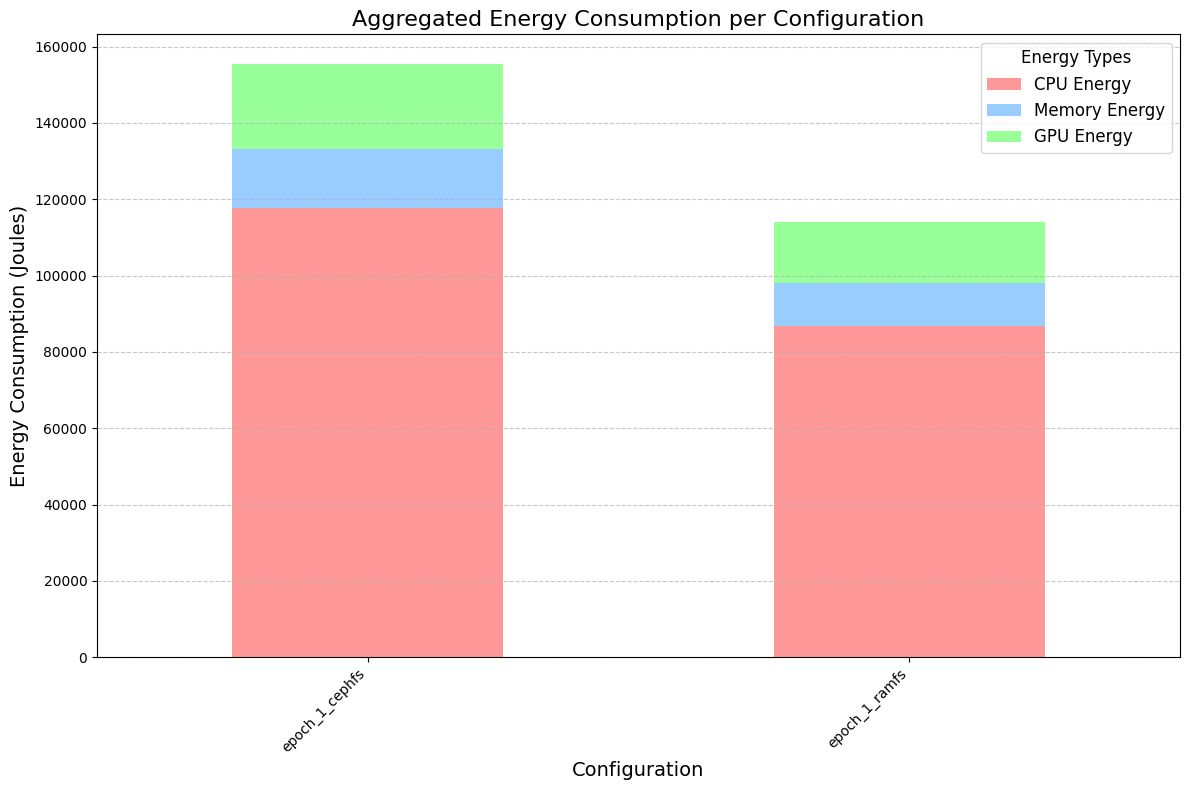

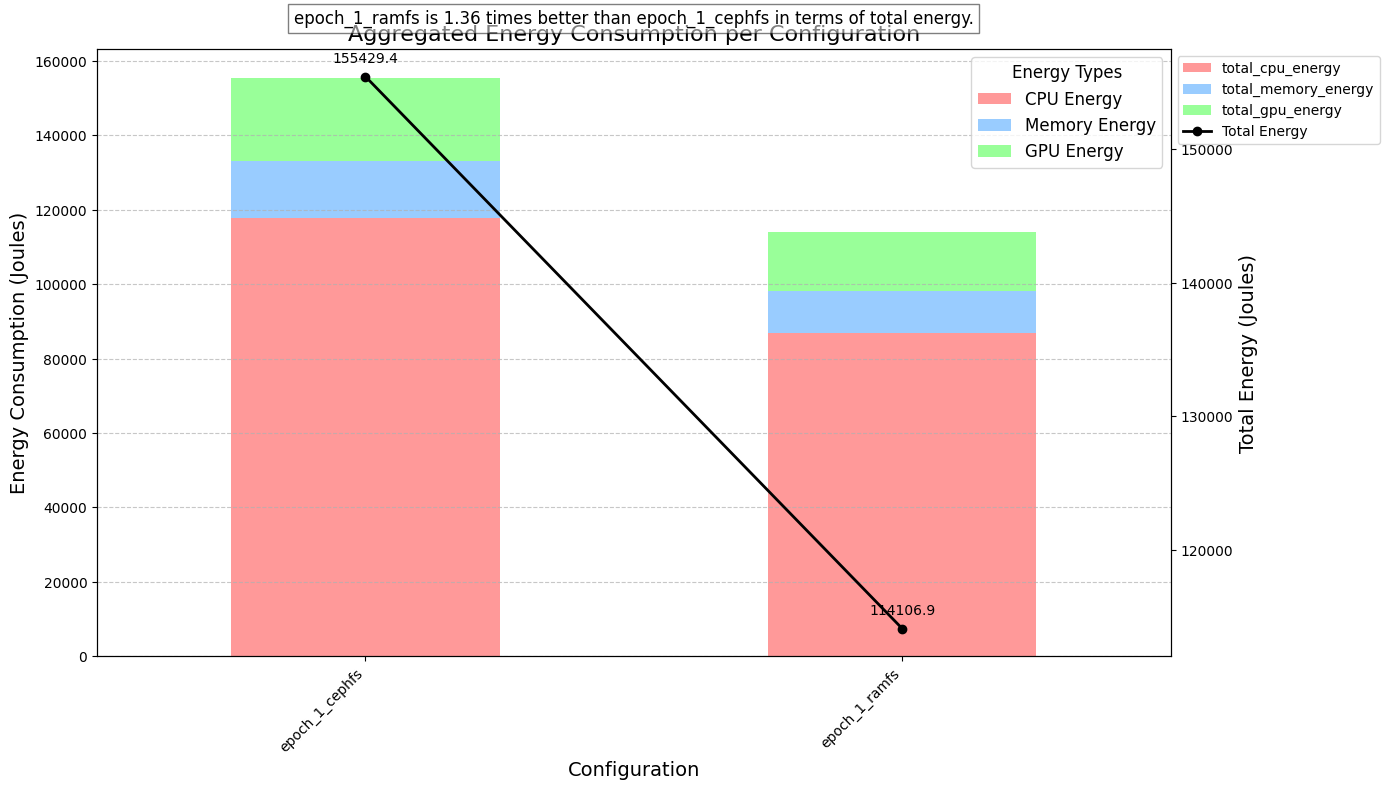

In [11]:
base_energies={"compute1":{"memory":13,"cpu":107,"gpu":51},"storage1":{"memory":15,"cpu":78,"gpu":0},"storage2":{"memory":7,"cpu":87,"gpu":0}}


list_of_files=["epoch_1_cephfs_result.txt" ,"epoch_1_ramfs_result.txt"]
base_directories= "/home/cc/MultiNodeEnergyTracker/results/"
df_list_epoch_1=[]
for file in list_of_files:
    # results= parse_training_result(base_directories+file)
    # print(f"for {file} results are {results}")
    # print(extract_epoch_mode_regex(base_directories+file))
    df_list_epoch_1.append(collect_and_process(base_directories+file))

final_df_epoch_1 = pd.concat(df_list_epoch_1)
df_final__epoch_1= aggregate_energy(final_df_epoch_1)
plot_total_energy(df_final__epoch_1)
plot_total_energy_with_comparison(df_final__epoch_1)


Processing mode 'cephfs' from 1734388895.1635313 to 1734389663.803208
Expected entries: 7687

Processing mode 'ramfs'
Prefetching phase from 1734388417.0086832 to 1734388537.5390286
Data loading phase from 1734388537.9835215 to 1734388860.7650955
Prefetching Duration: 120.53034543991089 seconds
Data Loading Duration: 322.781574010849 seconds
Starting Prefetching Phase Queries...
Starting Data Loading Phase Queries...


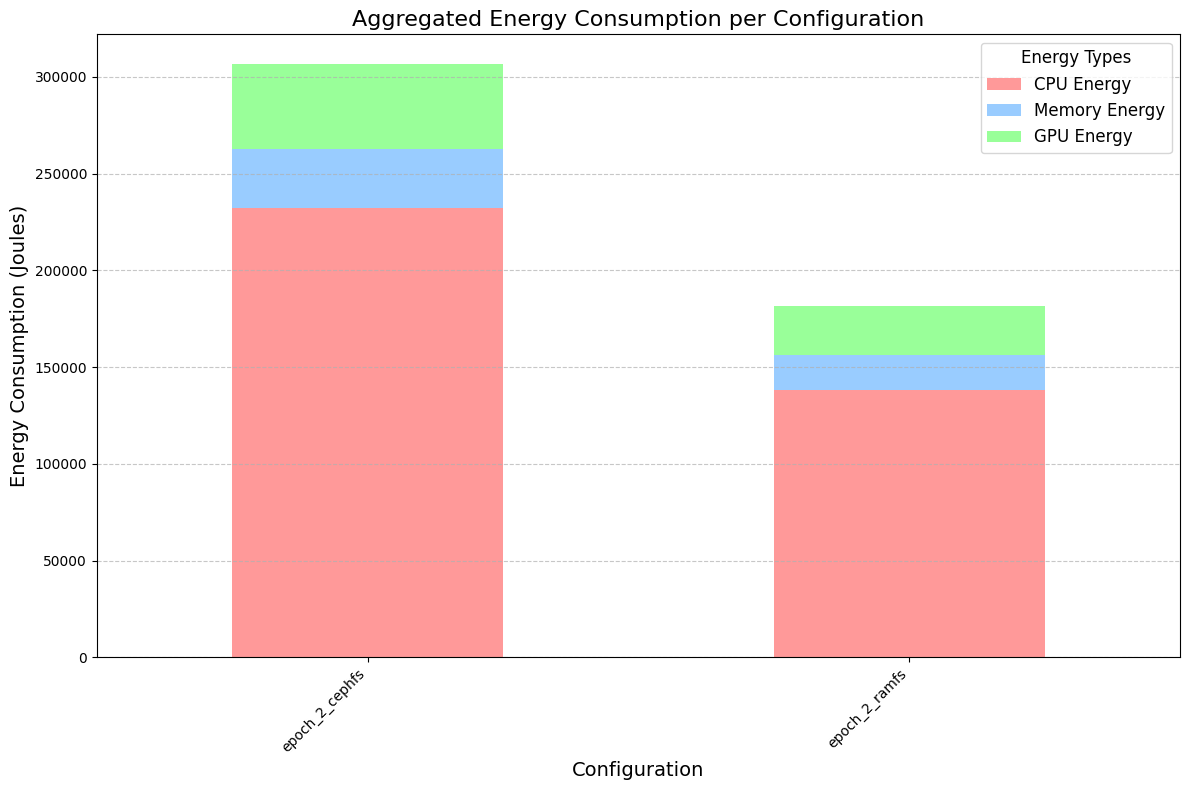

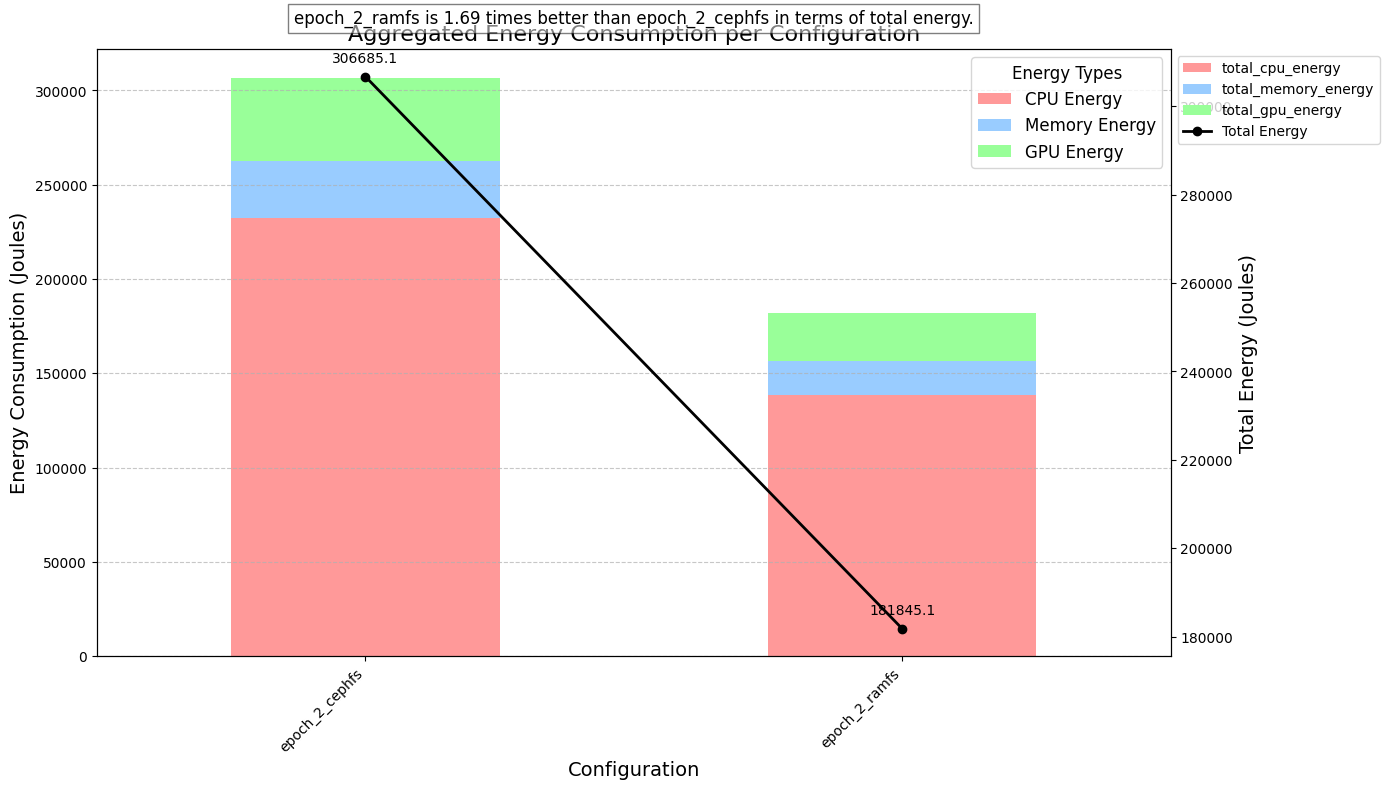

In [12]:
base_energies={"compute1":{"memory":13,"cpu":107,"gpu":51},"storage1":{"memory":15,"cpu":78,"gpu":0},"storage2":{"memory":7,"cpu":87,"gpu":0}}


list_of_files=["epoch_2_cephfs_result.txt" ,"epoch_2_ramfs_result.txt"]
base_directories= "/home/cc/MultiNodeEnergyTracker/results/"
df_list_epoch_2=[]
for file in list_of_files:
    # results= parse_training_result(base_directories+file)
    # print(f"for {file} results are {results}")
    # print(extract_epoch_mode_regex(base_directories+file))
    df_list_epoch_2.append(collect_and_process(base_directories+file))

final_df_epoch_2 = pd.concat(df_list_epoch_2)
df_final__epoch_2= aggregate_energy(final_df_epoch_2)
plot_total_energy(df_final__epoch_2)

plot_total_energy_with_comparison(df_final__epoch_2)




Processing mode 'cephfs' from 1734390509.3120122 to 1734392030.3378303
Expected entries: 15211

Processing mode 'ramfs'
Prefetching phase from 1734389711.0513957 to 1734389832.5206716
Data loading phase from 1734389832.959598 to 1734390475.4734395
Prefetching Duration: 121.4692759513855 seconds
Data Loading Duration: 642.5138413906097 seconds
Starting Prefetching Phase Queries...
Starting Data Loading Phase Queries...


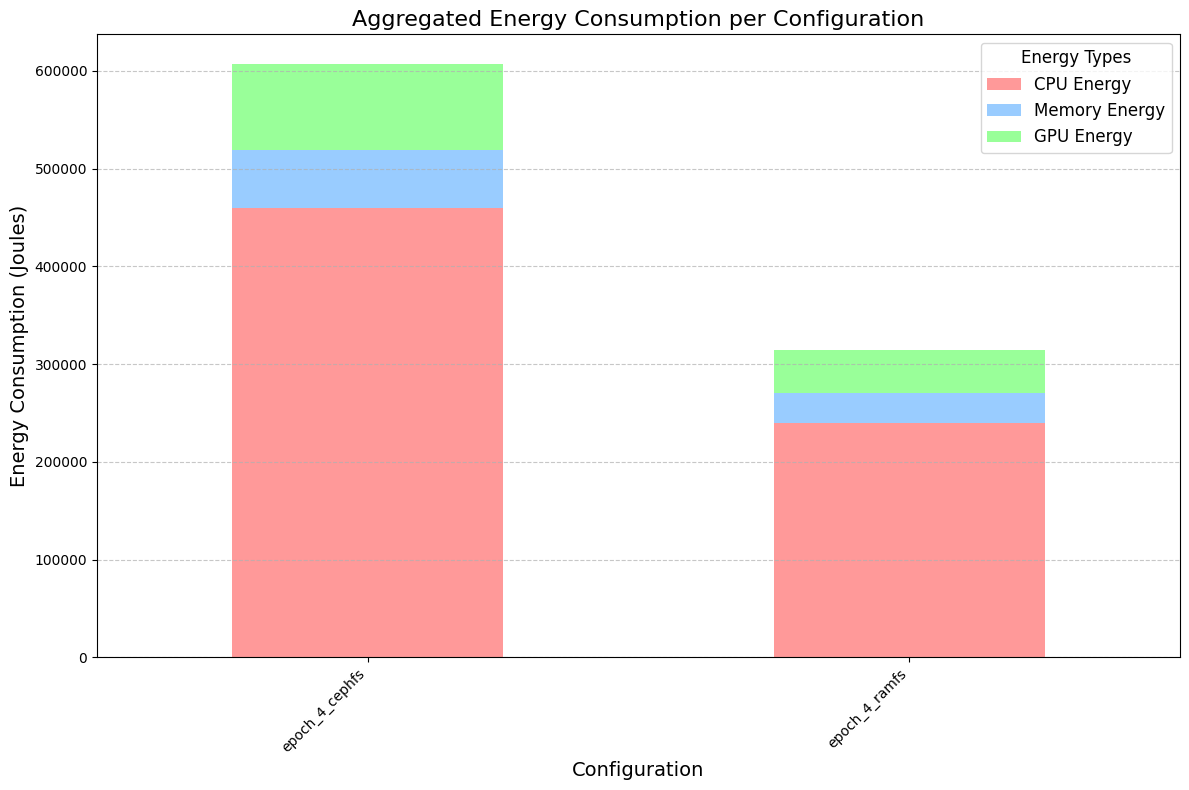

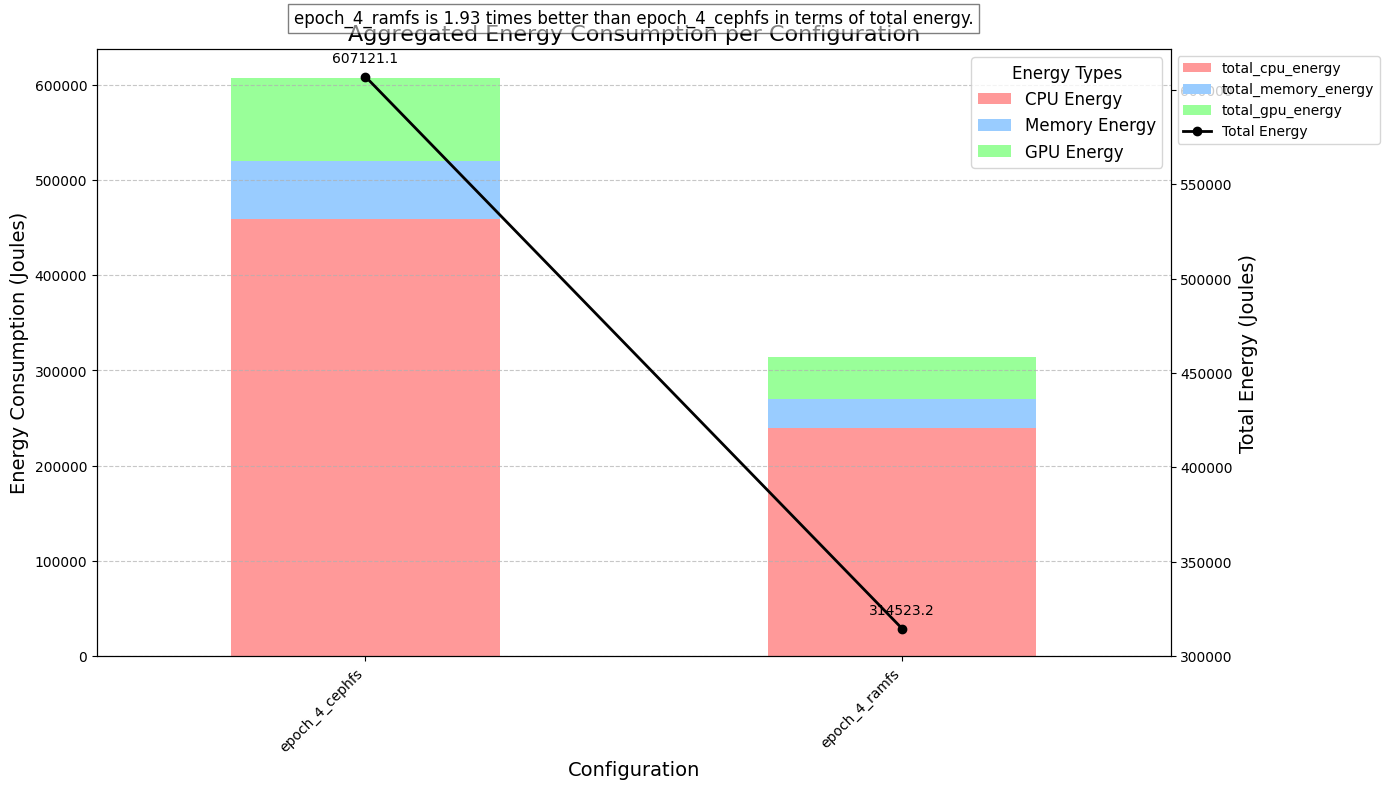

In [13]:
base_energies={"compute1":{"memory":13,"cpu":107,"gpu":51},"storage1":{"memory":15,"cpu":78,"gpu":0},"storage2":{"memory":7,"cpu":87,"gpu":0}}


list_of_files=["epoch_4_cephfs_result.txt" ,"epoch_4_ramfs_result.txt"]
base_directories= "/home/cc/MultiNodeEnergyTracker/results/"
df_list_epoch_4=[]
for file in list_of_files:
    # results= parse_training_result(base_directories+file)
    # print(f"for {file} results are {results}")
    # print(extract_epoch_mode_regex(base_directories+file))
    df_list_epoch_4.append(collect_and_process(base_directories+file))

final_df_epoch_4 = pd.concat(df_list_epoch_4)
df_final__epoch_4= aggregate_energy(final_df_epoch_4)
plot_total_energy(df_final__epoch_4)
plot_total_energy_with_comparison(df_final__epoch_4)



Processing mode 'cephfs' from 1734393515.1890433 to 1734396554.7874544
Expected entries: 30396

Processing mode 'ramfs'
Prefetching phase from 1734392080.6854281 to 1734392201.9766018
Data loading phase from 1734392202.4661286 to 1734393478.682701
Prefetching Duration: 121.29117369651794 seconds
Data Loading Duration: 1276.216572523117 seconds
Starting Prefetching Phase Queries...
Starting Data Loading Phase Queries...


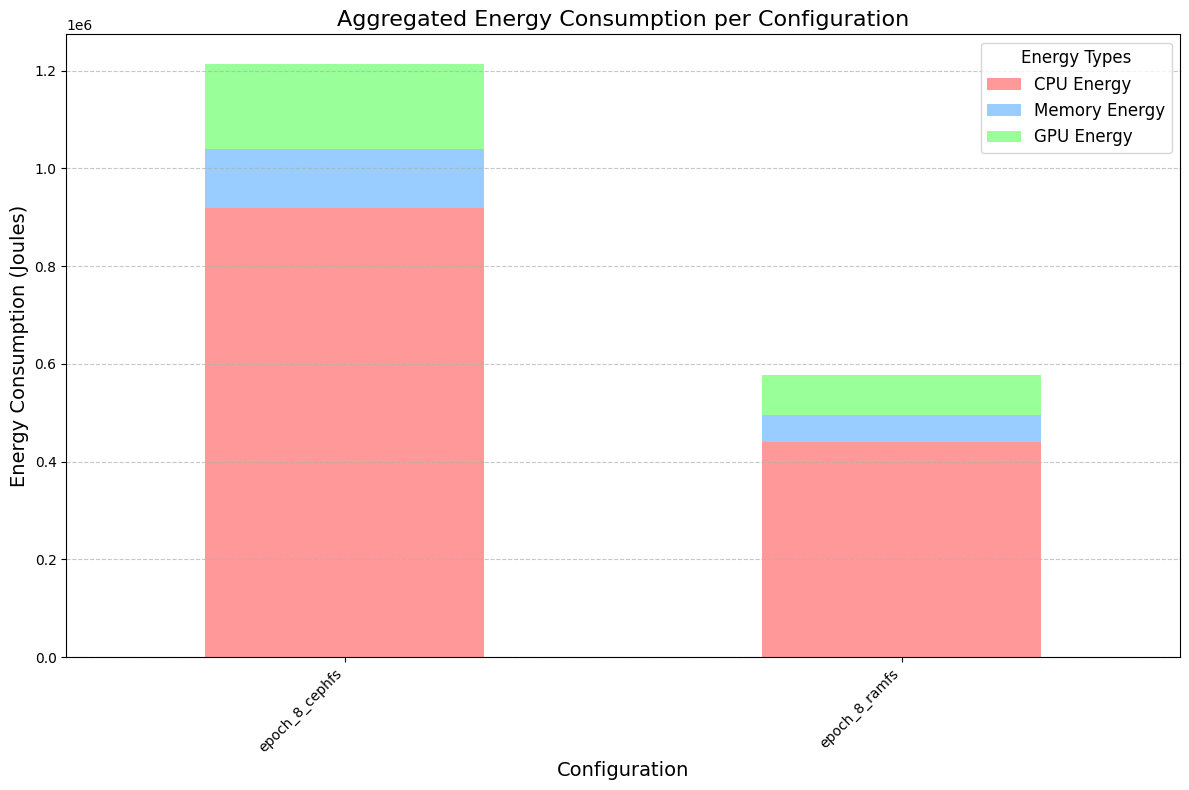

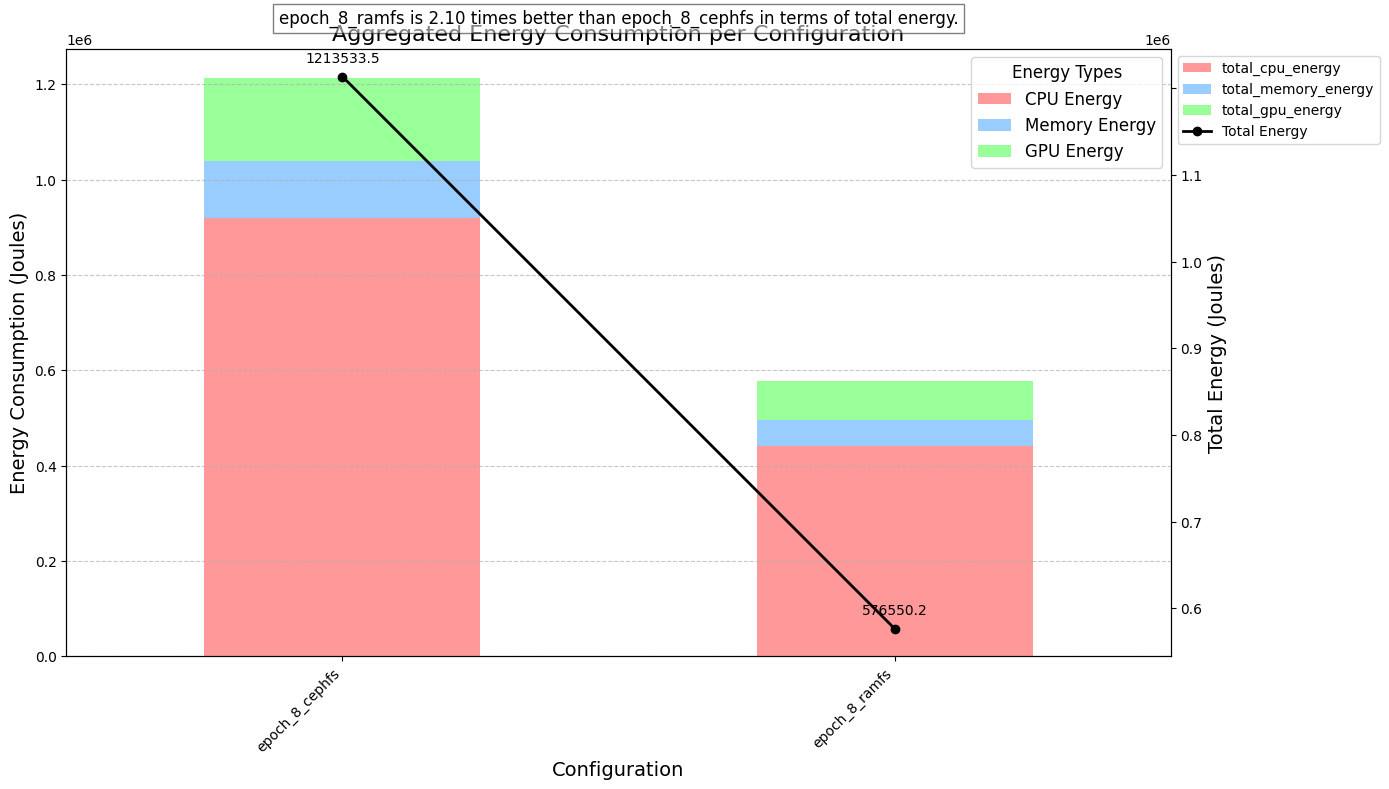

In [15]:
base_energies={"compute1":{"memory":13,"cpu":107,"gpu":51},"storage1":{"memory":15,"cpu":78,"gpu":0},"storage2":{"memory":7,"cpu":87,"gpu":0}}


list_of_files=["epoch_8_cephfs_result.txt" ,"epoch_8_ramfs_result.txt"]
base_directories= "/home/cc/MultiNodeEnergyTracker/results/"
df_list_epoch_8=[]
for file in list_of_files:
    # results= parse_training_result(base_directories+file)
    # print(f"for {file} results are {results}")
    # print(extract_epoch_mode_regex(base_directories+file))
    df_list_epoch_8.append(collect_and_process(base_directories+file))

final_df_epoch_8 = pd.concat(df_list_epoch_8)
df_final__epoch_8= aggregate_energy(final_df_epoch_8)
plot_total_energy(df_final__epoch_8)
plot_total_energy_with_comparison(df_final__epoch_8)
